In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW

from pickle import load


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import gc

import sys
sys.path.append("../src")
import FE
import dataset
import models
import util
from config import read_config, update_config
import train_helper
import infer_helper
import loss
import lrfinder
import optim
from metric import cal_mae_metric
from dataset import *
from models import get_model
from infer_helper import removeDPModule

In [3]:
config = read_config("LSTM3_TSF2")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/LSTM3_TSF2/


In [4]:
model = get_model(72, config)

In [5]:
model

Model(
  (seq_emb): Sequential(
    (0): Linear(in_features=72, out_features=256, bias=True)
    (1): SELU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj):

In [3]:
train, test = dataset.read_data(config)
#train_fe = FE.add_features_choice(train.copy(), config)

In [6]:
train["pred"] = 0
for fold in range(5):
    print(torch.load(f'{config.model_output_folder}/Fold_{fold}_best_model.pth')['best_valid_score'])
    train.loc[train.query(f"fold=={fold}").index, "pred"] = torch.load(f'{config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()

0.20192953554404208
0.20096651412289954
0.19292659975465118
0.20100927203807895
0.19541127994786625


In [7]:
train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"], df['pred'], 1-df["u_out"]))

fold
0    0.201930
1    0.200967
2    0.192927
3    0.201009
4    0.195411
dtype: float64

In [8]:
CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"], df['pred'], 1 - df["u_out"])).mean()
CV

0.1984486402815076

In [9]:
ids = train.query("fold==1").breath_id.unique()

In [10]:
def plot_error(train, ax, breath_id):
    breath = train.query(f"breath_id == {breath_id}").copy()
    R, C = breath.iloc[0][["R","C"]]
    breath = breath.loc[:breath["u_out"].idxmax()-1,]
    ax.plot(breath["time_step"],breath["pressure"],label="y_true")
    ax.plot(breath["time_step"],breath["pred"],label="y_pred")
    ax.plot(breath["time_step"],breath["u_in"],label="u_in")
    diff = breath["pressure"] - breath["pred"]
    ax2 = ax.twinx()
    ax2.plot(breath["time_step"], diff, label='diff', color="red")
    ax2.axhline(y=CV, color="red", linestyle="--", alpha=.3)
    ax2.axhline(y=0, color="red", linestyle="--", alpha=.3)
    ax2.axhline(y=-CV, color="red", linestyle="--", alpha=.3)
    ax.legend(loc="lower right")
    ax2.legend(loc="upper right")
    ax.set_title(f"id: {breath_id}, R:{R}, C:{C}")
    ax.grid(axis='x')

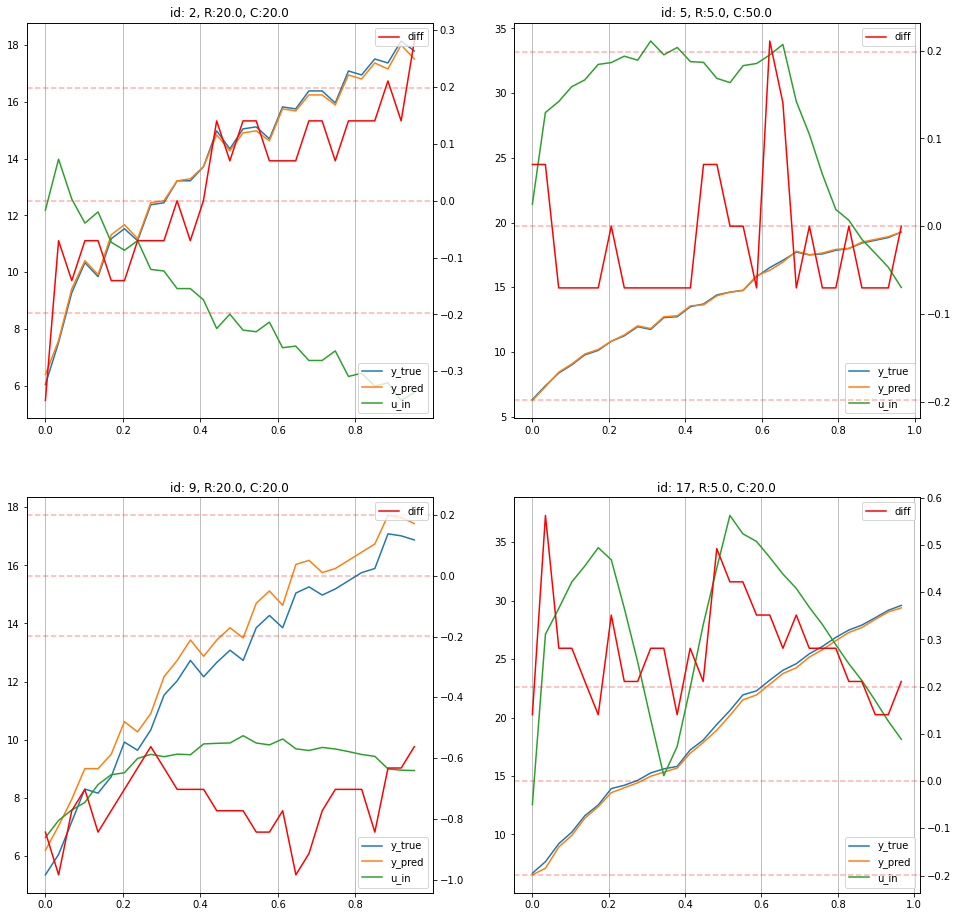

In [11]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[:4]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

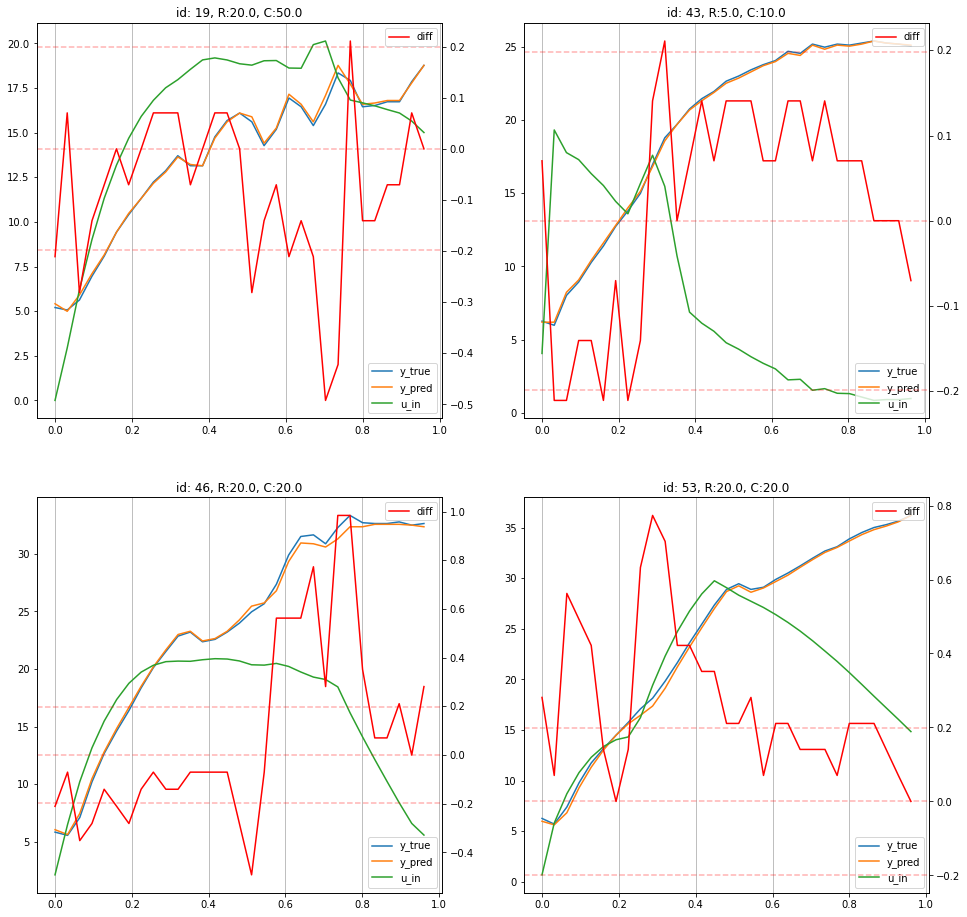

In [12]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[4:8]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

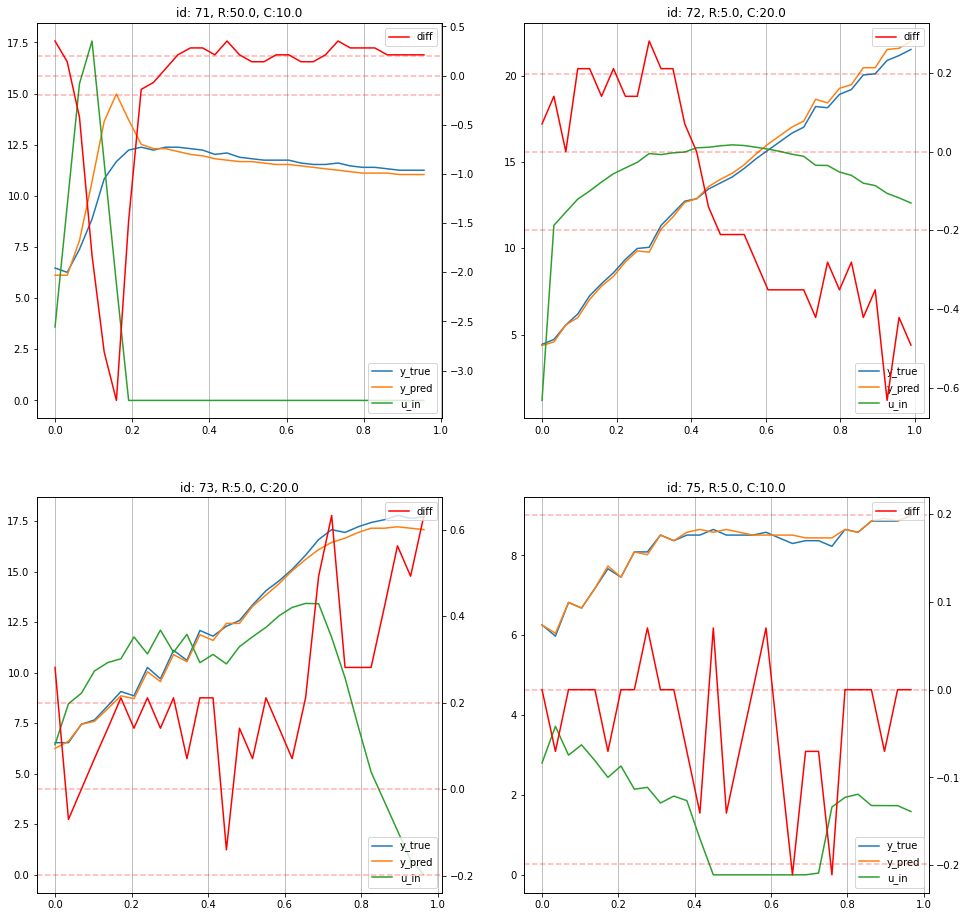

In [13]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[8:12]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

In [14]:
train["diff"] = train["pressure"] - train["pred"]

In [15]:
train["diff"].describe()

count    6.036000e+06
mean     4.540690e+00
std      4.597330e+00
min     -2.165306e+01
25%      7.030238e-02
50%      5.975682e+00
75%      6.678704e+00
max      5.476537e+01
Name: diff, dtype: float64

In [16]:
train.loc[train["diff"].idxmax()]["breath_id"]

52484.0

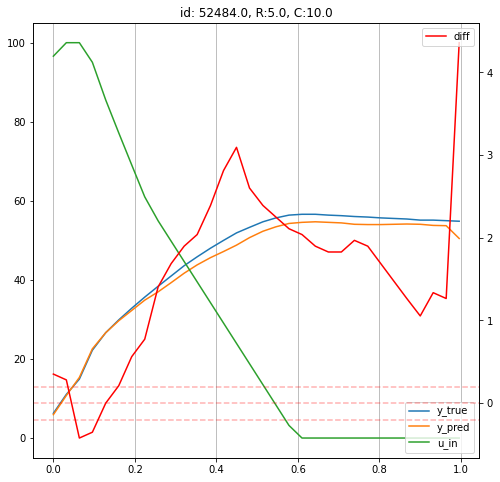

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_error(train, ax, train.loc[train["diff"].idxmax()]["breath_id"])
plt.show()

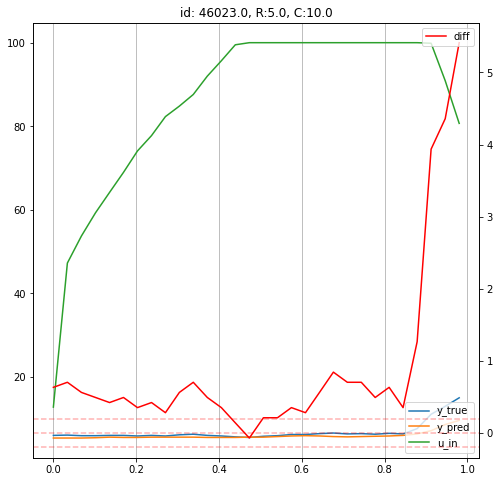

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_error(train, ax, train.loc[2213425]["breath_id"])
plt.show()

In [19]:
train.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'fold', 'pred', 'diff'],
      dtype='object')

In [20]:
train["abs_diff"] = train["diff"].abs() * (1-train["u_out"])
MAE_mean = train.query("u_out==0").groupby("breath_id")['abs_diff'].mean()

In [21]:
len(train["breath_id"].unique())

75450

In [22]:
len(MAE_mean)

75450

In [23]:
MAE_mean[MAE_mean>10]

breath_id
188      10.332072
74766    19.254676
Name: abs_diff, dtype: float64

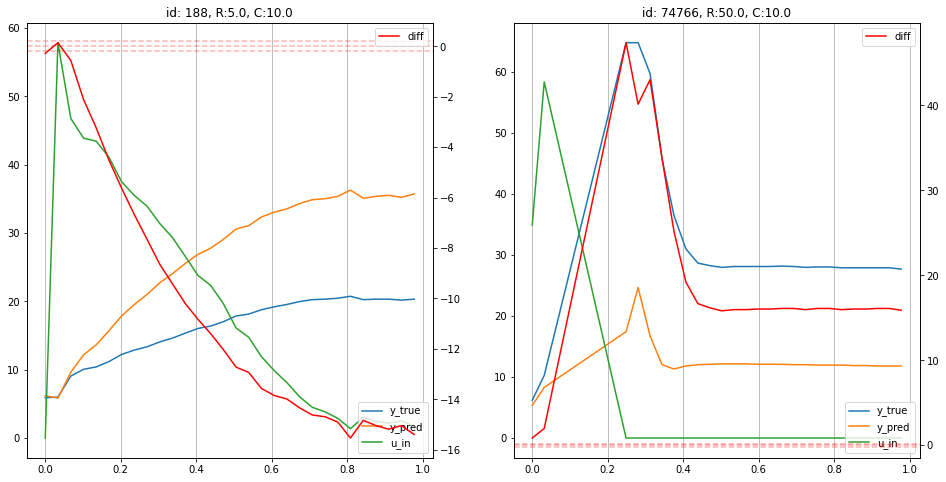

In [24]:
idxs = MAE_mean[MAE_mean>10].index
fig, axes = plt.subplots(1,len(idxs),figsize=(8*len(idxs),8))
for i, idx in enumerate(idxs):
    plot_error(train, axes[i], idx)
plt.show()

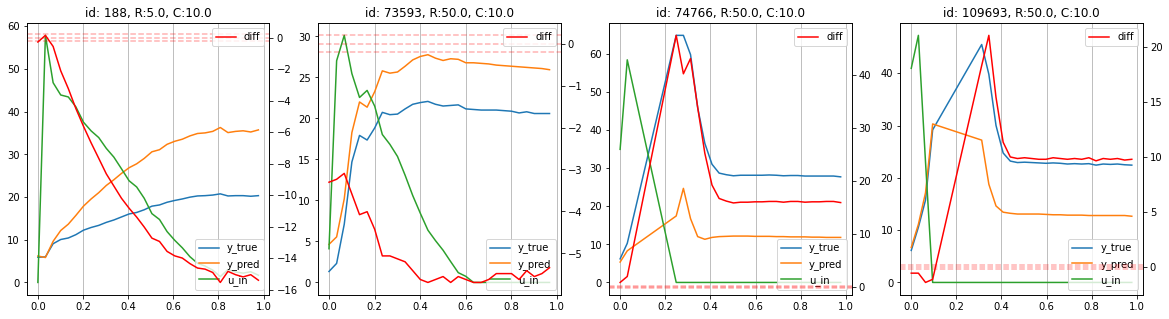

In [25]:
idxs = MAE_mean[MAE_mean>5].index
fig, axes = plt.subplots(1,len(idxs),figsize=(5*len(idxs),5))
for i, idx in enumerate(idxs):
    plot_error(train, axes[i], idx)
plt.show()

In [26]:
from tqdm import tqdm
from collections import defaultdict
RC_MAE_dict = defaultdict(list)
R_match = train.groupby("breath_id")["R"].first()
C_match = train.groupby("breath_id")["C"].first()
for idx in tqdm(MAE_mean.index):
    R,C = R_match.loc[idx], C_match.loc[idx]
    RC_MAE_dict[f"R{R}_C{C}"].append(MAE_mean.loc[idx])

100%|███████████████████████████████████████████████████████████| 75450/75450 [00:01<00:00, 53437.99it/s]


In [27]:
for key, maes in RC_MAE_dict.items():
    print(f"key: {key}, mean {np.mean(maes):.4f}, std {np.std(maes):.4f}, max {np.max(maes):.4f}")

key: R20_C50, mean 0.1797, std 0.1716, max 2.6715
key: R20_C20, mean 0.1834, std 0.2071, max 4.2928
key: R50_C20, mean 0.2743, std 0.4046, max 4.2181
key: R50_C50, mean 0.3056, std 0.4672, max 4.7805
key: R5_C50, mean 0.1330, std 0.1264, max 2.0959
key: R5_C20, mean 0.1405, std 0.1912, max 4.9541
key: R50_C10, mean 0.1902, std 0.3665, max 19.2547
key: R20_C10, mean 0.1892, std 0.2666, max 4.0728
key: R5_C10, mean 0.1777, std 0.2888, max 10.3321


In [28]:
len(MAE_mean[MAE_mean>4.3].index)

20

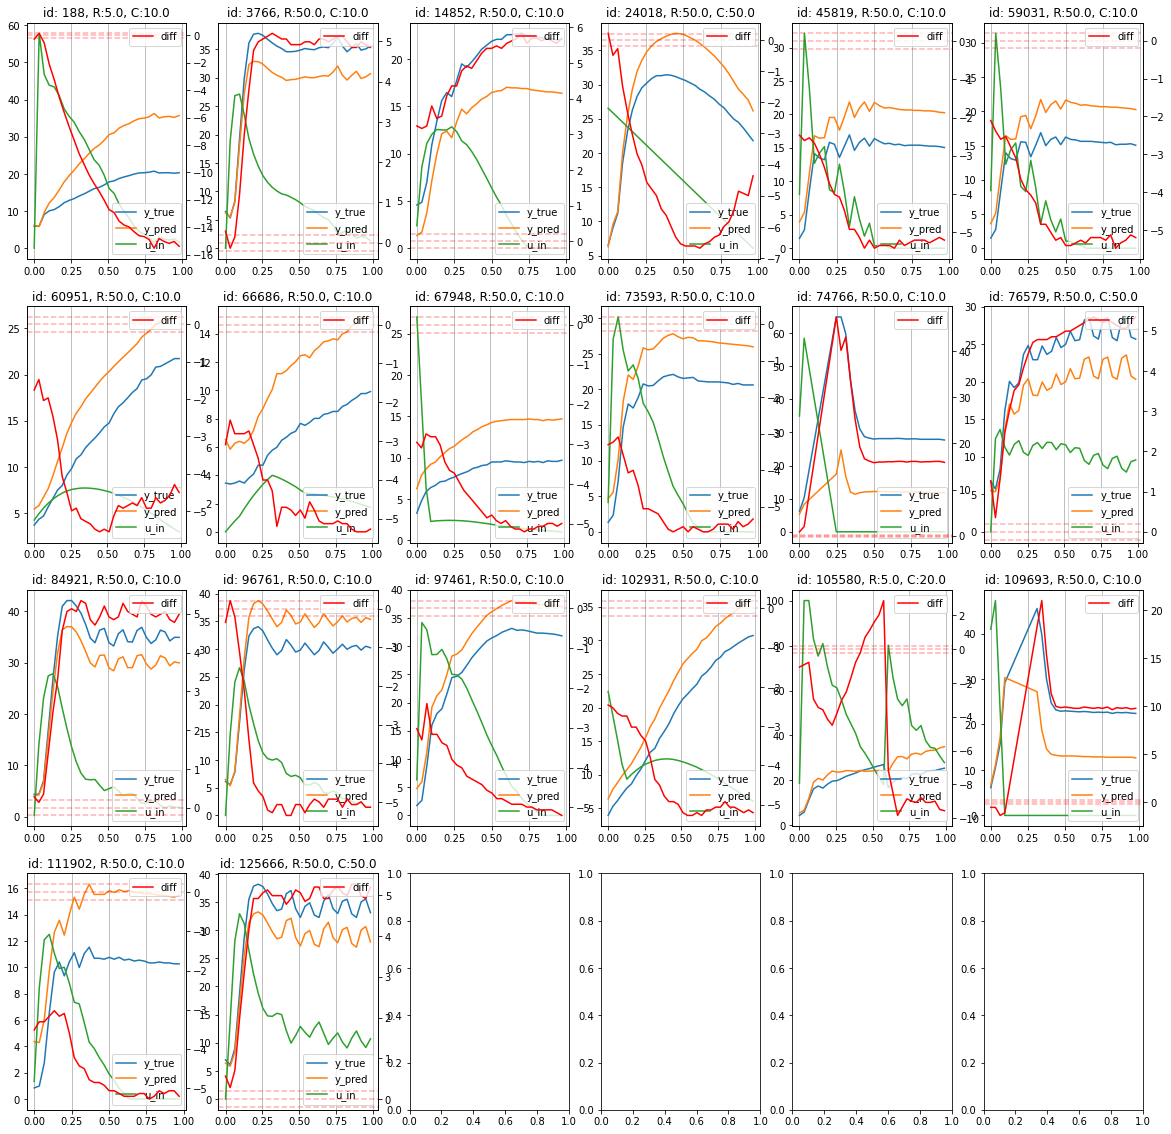

In [29]:
idxs = MAE_mean[MAE_mean>4.3].index
fig, axes = plt.subplots(4,len(idxs)//4+1,figsize=(20,20))
for i, idx in enumerate(idxs):
    plot_error(train, axes.flat[i], idx)
plt.show()

In [33]:
bad_mae = MAE_mean[MAE_mean > CV]
len(bad_mae)

18592

# Generate New Preds

In [38]:
bad_train = train.query(f"breath_id in {list(bad_mae.index)}").copy()

In [39]:
Rs = train["R"].unique()
Cs = train["C"].unique()


In [43]:
preds_df = bad_train[["id","breath_id","fold","pressure"]].copy()
preds_df["origin"] = 0
for R in Rs:
    for C in Cs:
        preds_df[f"R_{R}_C{C}"] = 0

for fold in tqdm(range(5)):
    fold_bad_train = bad_train.query(f"fold == {fold}").copy()
    scaler = load(open(config.model_output_folder + f'/scaler_{fold}.pkl', 'rb'))
    
    y_test = fold_bad_train["pressure"].values.reshape(-1, 80)
    w_test = 1 - fold_bad_train["u_out"].values.reshape(-1, 80)
    
    original_fe = FE.add_features_choice(fold_bad_train.copy(), config)
    feature_cols = [col for col in original_fe.columns if col not in ["id", "breath_id", "fold", "pressure", "pred", "diff", "abs_diff"]]
    no_transform_cols = ['u_out', 'u_out_diff', "u_out_diff_back1", "u_out_diff_back2",
                         'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50',
                         'R_C_20_10', 'R_C_20_20', 'R_C_20_50', 'R_C_50_10', 'R_C_50_20',
                         'R_C_50_50', 'R_C_5_10', 'R_C_5_20', 'R_C_5_50']
    transform_cols = [col for col in feature_cols if col not in no_transform_cols]   
    
    original_fe[transform_cols] = scaler.transform(original_fe[transform_cols])    
    
    X_test = original_fe[feature_cols].values.reshape(-1, 80, len(feature_cols))

    model = get_model(X_test.shape[-1], config)
    checkpoint = torch.load(f'{config.model_output_folder}/Fold_{fold}_best_model.pth')
    model.load_state_dict(removeDPModule(checkpoint['model_state_dict']))
    model.to(device=config.device)
    
    
    data_retriever = VPP(X_test, y_test, w_test, config)
    data_loader = DataLoader(data_retriever,
                             batch_size=config.batch_size//2,
                             shuffle=False,
                             num_workers=config.num_workers, pin_memory=True, drop_last=False)
    pred = infer_helper.get_pred(data_loader, model, config.device)    
    preds_df.loc[preds_df.query(f"fold=={fold}").index, "origin"] = pred.flatten()
    fold_bad_train_copy = fold_bad_train.copy()
    for R in Rs:
        for C in Cs:
            print(R, C)
            fold_bad_train_copy["R"] = R
            fold_bad_train_copy["C"] = C
            new_fe = FE.add_features_choice(fold_bad_train_copy.copy(), config)
            new_fe[transform_cols] = scaler.transform(new_fe[transform_cols])    

            X_test = new_fe[feature_cols].values.reshape(-1, 80, len(feature_cols))
            data_retriever = VPP(X_test, y_test, w_test, config)
            data_loader = DataLoader(data_retriever,
                                     batch_size=config.batch_size//2,
                                     shuffle=False,
                                     num_workers=config.num_workers, pin_memory=True, drop_last=False)
            new_pred = infer_helper.get_pred(data_loader, model, config.device)    
            preds_df.loc[preds_df.query(f"fold=={fold}").index, f"R_{R}_C{C}"] = new_pred.flatten()

  0%|                                                                              | 0/5 [00:00<?, ?it/s]

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 50
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 20
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 10
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expa

 20%|██████████████                                                        | 1/5 [00:48<03:13, 48.34s/it]

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 50
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 20
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 10
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expa

 40%|████████████████████████████                                          | 2/5 [01:37<02:26, 48.95s/it]

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 50
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 20
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 10
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expa

 60%|██████████████████████████████████████████                            | 3/5 [02:24<01:35, 47.90s/it]

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 50
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 20
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 10
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expa

 80%|████████████████████████████████████████████████████████              | 4/5 [03:13<00:48, 48.47s/it]

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 50
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 20
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
20 10
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expa

100%|██████████████████████████████████████████████████████████████████████| 5/5 [04:00<00:00, 48.14s/it]


KeyError: "Columns not found: 'R', 'C'"

In [49]:
preds_df = preds_df.merge(bad_train[["id","breath_id","R","C","u_out"]], on=["id","breath_id"])

In [51]:
preds_df

,id,breath_id,fold,pressure,origin,R_20_C50,R_20_C20,R_20_C10,R_50_C50,R_50_C20,R_50_C10,R_5_C50,R_5_C20,R_5_C10,R,C,u_out
0,241,4,0,6.259305,6.329606,6.048398,6.048398,5.837492,6.329606,6.399909,6.329606,6.540513,6.259304,5.978096,50,50,0
1,242,4,0,5.767190,5.556283,5.485981,5.626585,5.696887,5.556283,5.837492,6.259304,6.329606,5.978096,5.626585,50,50,0
2,243,4,0,6.540513,6.540513,6.259304,5.978096,5.837492,6.540513,6.259304,6.189002,6.821721,6.470211,5.837492,50,50,0
3,244,4,0,8.649578,8.719879,7.102930,7.384139,6.118700,8.719879,7.876254,6.399909,7.032628,6.470211,5.978096,50,50,0
4,245,4,0,10.758642,10.899246,8.368369,9.282296,6.892024,10.899246,10.196224,6.892024,7.454441,7.243534,6.751419,50,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487355,6035916,125745,1,7.313837,0.002414,0.002414,-0.067889,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,50,50,1
1487356,6035917,125745,1,7.102930,0.002414,0.002414,-0.067889,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,50,50,1
1487357,6035918,125745,1,6.540513,0.002414,0.002414,-0.067889,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,50,50,1
1487358,6035919,125745,1,7.032628,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,0.002414,50,50,1


In [52]:
score_df = preds_df.groupby("breath_id")[["R","C"]].last()
for col in ["origin"] + [f"R_{R}_C{C}" for R in Rs for C in Cs]:    
    score_df[col] = preds_df.groupby("breath_id").apply(lambda df: cal_mae_metric(df["pressure"], df[col], 1-df["u_out"]))

In [54]:
cols = ["origin"] + [f"R_{R}_C{C}" for R in Rs for C in Cs]
score_df["lowest_col"] = score_df.apply(lambda s: s.loc[cols].idxmin(),axis=1)

In [56]:
score_df["lowest_score"] = score_df.apply(lambda s: s.loc[s["lowest_col"]], axis=1)

In [57]:
score_df

,R,C,origin,R_20_C50,R_20_C20,R_20_C10,R_50_C50,R_50_C20,R_50_C10,R_5_C50,R_5_C20,R_5_C10,lowest_col,lowest_score
breath_id,,,,,,,,,,,,,,
4,50,50,0.213104,9.532532,5.266070,5.843866,0.213104,0.753551,7.794750,12.230377,9.815938,7.098320,origin,0.213104
7,50,20,0.288481,2.385425,0.853323,1.437558,0.399995,0.288481,1.992702,1.898158,2.366031,1.481193,origin,0.288481
9,20,20,0.751505,1.006048,0.751505,2.606027,6.395070,8.865342,4.867817,2.865419,0.431510,1.803613,R_5_C20,0.431510
16,50,50,0.308423,5.347499,4.252146,2.998047,0.308423,0.455830,3.276987,5.989289,4.079793,3.147722,origin,0.308423
17,5,20,0.276361,2.070276,4.324794,3.408441,5.982954,5.844774,3.779346,5.723565,0.276361,2.955114,origin,0.276361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125717,20,50,0.292548,0.292548,3.644372,2.424290,3.118240,2.027423,5.585619,3.927849,2.174831,2.029691,origin,0.292548
125723,50,20,0.244924,7.148141,4.685298,3.252041,0.433152,0.244924,3.710139,7.944143,5.376981,4.243075,origin,0.244924
125726,50,10,0.400722,6.277982,5.050038,1.991894,1.860663,1.572425,0.400722,5.574960,6.434990,2.352778,origin,0.400722


In [58]:
score_df["improvement"] = score_df["origin"] - score_df["lowest_score"]

In [59]:
score_df["improvement"].describe()

count    18592.000000
mean         0.058089
std          0.300225
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.889169
Name: improvement, dtype: float64

In [80]:
impr_part = score_df[score_df["improvement"]>1e-4].copy()
impr_part

,R,C,origin,R_20_C50,R_20_C20,R_20_C10,R_50_C50,R_50_C20,R_50_C10,R_5_C50,R_5_C20,R_5_C10,lowest_col,lowest_score,improvement
breath_id,,,,,,,,,,,,,,,
9,20,20,0.751505,1.006048,0.751505,2.606027,6.395070,8.865342,4.867817,2.865419,0.431510,1.803613,R_5_C20,0.431510,0.319996
42,50,20,0.247270,0.540599,0.492115,1.919976,0.184240,0.247270,2.012096,0.654537,0.656961,1.590283,R_50_C50,0.184240,0.063030
71,50,10,0.496651,2.746320,1.687252,1.029586,3.750959,3.286058,0.496651,2.245133,1.666841,0.240388,R_5_C10,0.240388,0.256263
92,50,50,0.731582,8.532923,5.514325,2.796707,0.731582,0.584386,2.566028,10.112525,8.673528,3.271247,R_50_C20,0.584386,0.147196
94,50,10,0.320754,1.250060,1.298393,0.318556,0.511888,0.325148,0.320754,1.827856,0.993018,0.309769,R_5_C10,0.309769,0.010985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125653,20,50,0.266663,0.266663,2.164821,4.404793,3.265413,7.284757,9.553819,0.126059,1.098168,4.513882,R_5_C50,0.126059,0.140604
125666,50,50,4.429036,18.386208,12.118333,7.814523,4.429036,0.325148,1.272030,20.370047,16.542974,9.159052,R_50_C20,0.325148,4.103889
125680,20,10,0.412440,0.770980,1.534930,0.412440,0.489772,0.571791,0.571790,1.293560,0.297612,0.892838,R_5_C20,0.297612,0.114827


In [81]:
impr_part["improvement"].sort_values()

breath_id
49159     0.002197
1025      0.002197
80292     0.002198
65352     0.002268
23873     0.002268
            ...   
59031     3.962697
45819     4.063464
125666    4.103889
73593     4.398570
188       9.889169
Name: improvement, Length: 2063, dtype: float64

In [82]:
from collections import Counter
Counter(impr_part["lowest_col"])

Counter({'R_5_C20': 205,
         'R_50_C50': 287,
         'R_5_C10': 229,
         'R_50_C20': 463,
         'R_20_C20': 210,
         'R_20_C10': 228,
         'R_20_C50': 155,
         'R_5_C50': 129,
         'R_50_C10': 157})

In [62]:
score_df[score_df["improvement"]>0]["improvement"].sum()

1079.996976866097

In [65]:
train.query("breath_id==1").u_out.sum()

50

In [67]:
(1079.996976866097 * 30) / (1-train["u_out"]).sum()

0.014142453891098831

In [ ]:
for fold in range(5):

In [97]:
idx = 84921
breath_eg = train.query(f"breath_id == {idx}").copy()

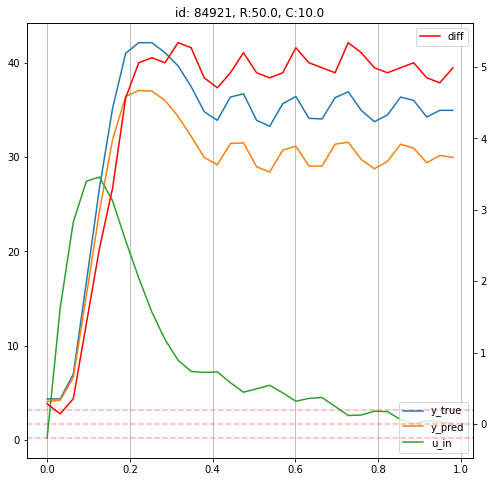

In [100]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_error(train, ax, idx)
plt.show()

In [101]:
fold = breath_eg["fold"].iloc[0]
y_test = breath_eg["pressure"].values.reshape(-1, 80)
w_test = 1 - breath_eg["u_out"].values.reshape(-1, 80)
original_fe = FE.add_features_choice(breath_eg.copy(), config)
original_fe[transform_cols] = scaler.transform(original_fe[transform_cols])

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']


In [102]:
def get_RC_cols(R,C):
    return "R_"+str(int(R)), "C_"+str(int(C)), "R_C_" + str(int(R)) + "_" + str(int(C))
oR, oC  = breath_eg.iloc[0,[2,3]]
oR_col, oC_col, oR_C_col = get_RC_cols(oR, oC)

In [103]:
X_test = original_fe[feature_cols].values.reshape(-1, 80, len(feature_cols))
data_retriever = VPP(X_test, y_test, w_test, config)
data_loader = DataLoader(data_retriever,
                         batch_size=config.batch_size//2,
                         shuffle=False,
                         num_workers=config.num_workers, pin_memory=True, drop_last=False)
pred = infer_helper.get_pred(data_loader, model, config.device)

In [104]:
origin_score = cal_mae_metric(y_test.flatten(), pred.flatten(), w_test.flatten())
print(f"origin_score (R {int(oR)} C {int(oC)}): {origin_score:.4f}")

origin_score (R 50 C 10): 4.3170


In [105]:
breath_eg.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,pred,diff,abs_diff
4071920,4071921,84921,50,10,0.000000,0.214098,0,4.361147,4,4.079938,0.281209,0.281209
4071921,4071922,84921,50,10,0.031610,13.994769,0,4.361147,4,4.220542,0.140605,0.140605
4071922,4071923,84921,50,10,0.063238,23.092606,0,6.962326,4,6.610815,0.351511,0.351511
4071923,4071924,84921,50,10,0.094901,27.433899,0,16.734324,4,15.328281,1.406043,1.406043
4071924,4071925,84921,50,10,0.126549,27.869596,0,26.717229,4,24.256653,2.460576,2.460576


In [106]:
for R in Rs:
    for C in Cs:
        breath_eg["R"] = R
        breath_eg["C"] = C
        original_fe = FE.add_features_choice(breath_eg.copy(), config)
        original_fe[transform_cols] = scaler.transform(original_fe[transform_cols])
        X_test = original_fe[feature_cols].values.reshape(-1, 80, len(feature_cols))
        data_retriever = VPP(X_test, y_test, w_test, config)
        data_loader = DataLoader(data_retriever,
                                 batch_size=config.batch_size//2,
                                 shuffle=False,
                                 num_workers=config.num_workers, pin_memory=True, drop_last=False)
        pred = infer_helper.get_pred(data_loader, model, config.device)
        new_score = cal_mae_metric(y_test.flatten(), pred.flatten(), w_test.flatten())
        print(f"score (R {int(R)} C {int(C)}): {new_score:.4f}")        
        breath_eg["R"] = oR
        breath_eg["C"] = oC

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
score (R 20 C 50): 19.8472
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
score (R 20 C 20): 14.6119
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']
score (R 20 C 10): 9.5809
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate R C features ---
Drop Low I